Import Data

In [3]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Load Data

In [5]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
mnist.data.shape

(70000, 784)

Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.

In [7]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale X down. A commonly used range is [0, 1].

In [8]:
X /= 255.0

In [9]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [12]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

Print a selection of training images and their labels

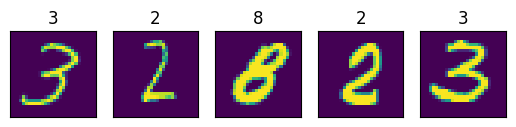

In [13]:
    #Plot the first 5 images and their labels in a row.
def plot_example(X, y):
  for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

plot_example(X_train, y_train)

Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [17]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [18]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [19]:
from skorch import NeuralNetClassifier

In [20]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [21]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8387       0.8800        0.4174  1.4519
      2        0.4332       0.9103        0.3133  1.2923
      3        0.3612       0.9233        0.2684  1.2187
      4        0.3233       0.9309        0.2317  0.9294
      5        0.2938       0.9353        0.2173  0.9164
      6        0.2738       0.9390        0.2039  0.9241
      7        0.2600       0.9454        0.1868  0.9017
      8        0.2427       0.9484        0.1757  0.9270
      9        0.2362       0.9503        0.1683  0.9075
     10        0.2226       0.9512        0.1621  0.9322
     11        0.2184       0.9529        0.1565  0.9220
     12        0.2090       0.9541        0.1508  0.9115
     13        0.2067       0.9570        0.1446  0.9229
     14        0.1978       0.9570        0.1412  1.1539
     15        0.1923       0.9582        0.1392  1.2533
     16        0.1889       0.9

Prediction

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
y_pred = net.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9631428571428572

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [25]:
error_mask = y_pred != y_test

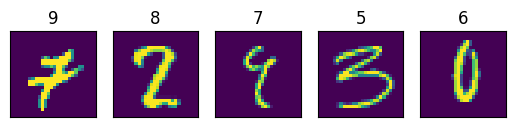

In [26]:
plot_example(X_test[error_mask], y_pred[error_mask])

Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [27]:
XCnn = X.reshape(-1, 1, 28, 28)

In [28]:
XCnn.shape

(70000, 1, 28, 28)

In [29]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [30]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [31]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [32]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [33]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4314       0.9716        0.0900  2.0375
      2        0.1635       0.9804        0.0628  1.6100
      3        0.1336       0.9838        0.0554  2.0614
      4        0.1130       0.9851        0.0499  1.5788
      5        0.1016       0.9863        0.0446  1.5872
      6        0.0959       0.9880        0.0398  1.6118
      7        0.0860       0.9870        0.0410  1.5639
      8        0.0837       0.9879        0.0382  1.5936
      9        0.0804       0.9894        0.0356  1.5735
     10        0.0758       0.9893        0.0364  1.8898


In [34]:
y_pred_cnn = cnn.predict(XCnn_test)

In [35]:
accuracy_score(y_test, y_pred_cnn)

0.9866857142857143

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [36]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7488372093023256

Over 70% of the previously misclassified images are now correctly identified.

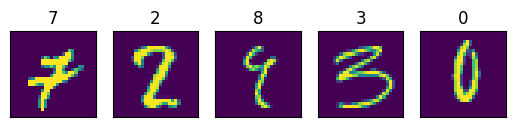

In [37]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])